In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


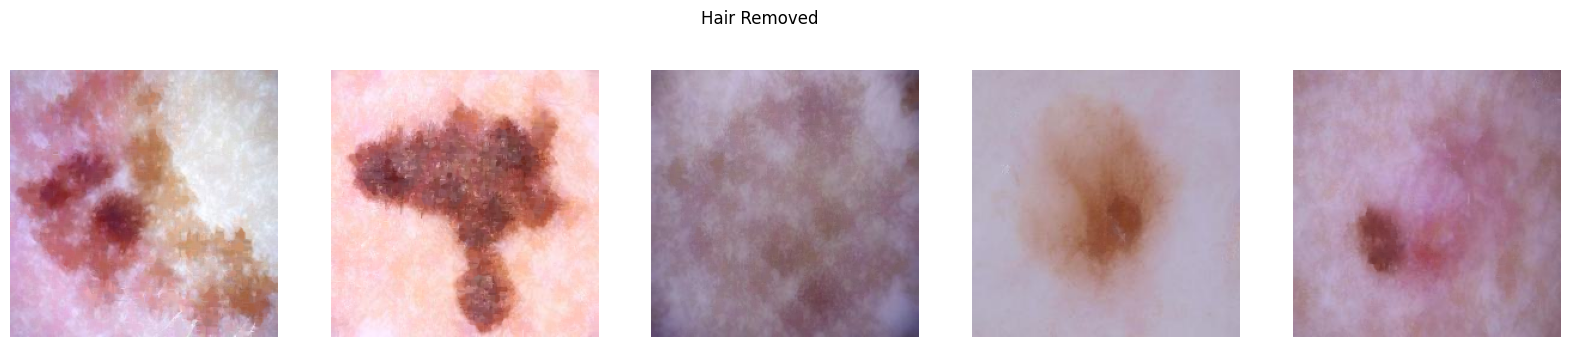

In [ ]:
def remove_hair(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    result = cv2.inpaint(img, cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), 1, cv2.INPAINT_TELEA)
    return result

sample_paths = glob("/content/drive/MyDrive/ISIC Dataset/Train/Benign/*.jpg")[:5]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    no_hair = remove_hair(img)
    axs[i].imshow(no_hair)
    axs[i].axis('off')
plt.suptitle("Hair Removed")
plt.show()


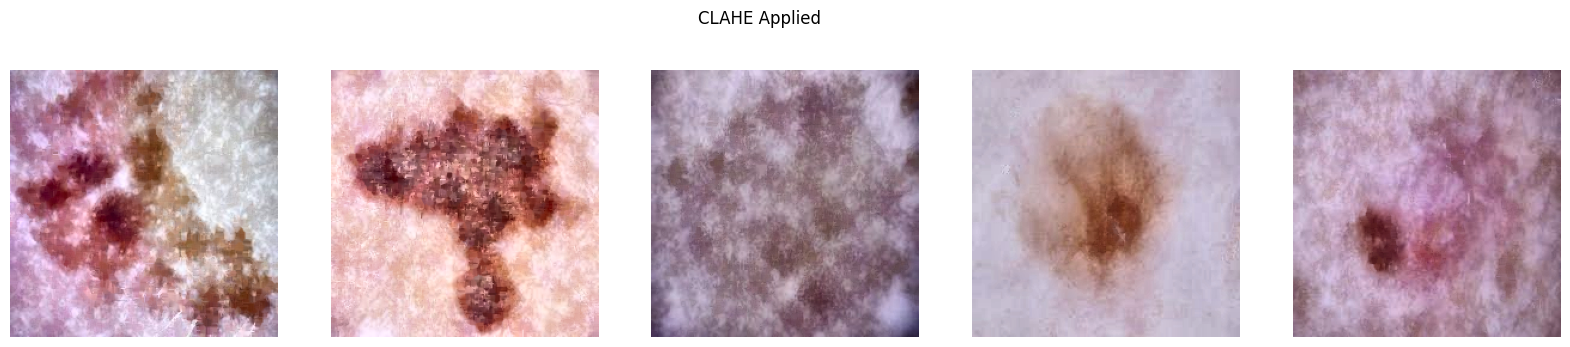

In [ ]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    no_hair = remove_hair(img)
    eq = apply_clahe(no_hair)
    axs[i].imshow(eq)
    axs[i].axis('off')
plt.suptitle("CLAHE Applied")
plt.show()


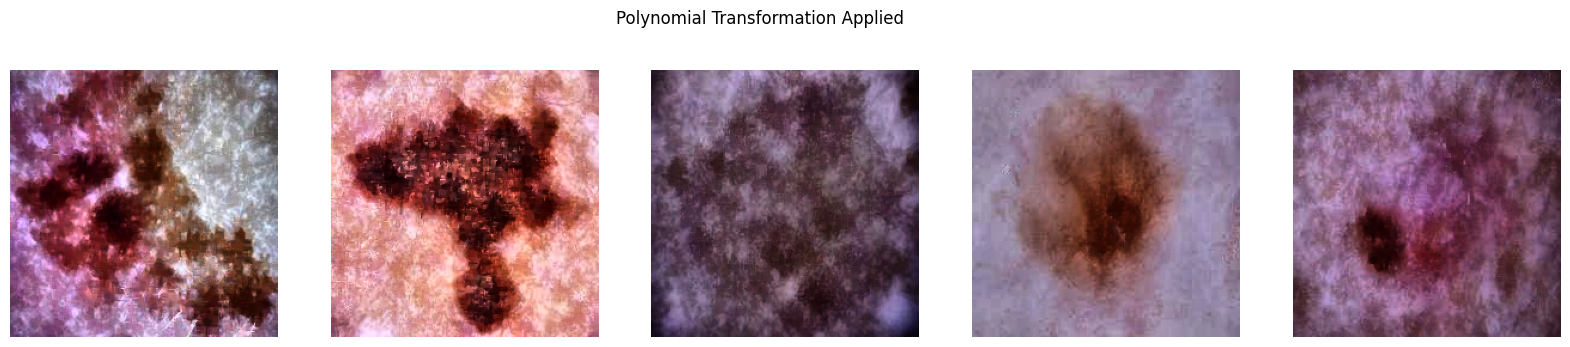

In [ ]:
def poly_transform(img):
    img = img.astype(np.float32) / 255.0
    poly_img = np.power(img, 2.0)
    poly_img = (poly_img * 255).astype(np.uint8)
    return poly_img


fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    processed = poly_transform(apply_clahe(remove_hair(img)))
    axs[i].imshow(processed)
    axs[i].axis('off')
plt.suptitle("Polynomial Transformation Applied")
plt.show()


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomSkinDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.dataset = ImageFolder(root_dir)
        self.transform = transform
        self.augment = augment

    def __getitem__(self, idx):
        img_path, label = self.dataset.imgs[idx]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = remove_hair(img)
        img = apply_clahe(img)
        #img = poly_transform(img)
        img = Image.fromarray(img)
        if self.augment:
            img = self.transform(img)
        else:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])



In [ ]:

train_data = CustomSkinDataset("/content/drive/MyDrive/ISIC Dataset/Train", transform=train_transform, augment=True)
val_data = CustomSkinDataset("/content/drive/MyDrive/ISIC Dataset/Val", transform=test_transform)
test_data = CustomSkinDataset("/content/drive/MyDrive/ISIC Dataset/Test", transform=test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


In [8]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 101MB/s] 


In [ ]:
best_acc = 0
for epoch in range(15):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Loss: {train_loss/len(train_loader):.4f}")

    
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    print(f"Validation Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best Model Saved")


100%|██████████| 84/84 [17:54<00:00, 12.79s/it]


Epoch 1, Train Acc: 80.95%, Loss: 0.4054


100%|██████████| 21/21 [08:06<00:00, 23.18s/it]


Validation Acc: 81.63%
Best Model Saved


100%|██████████| 84/84 [01:04<00:00,  1.31it/s]


Epoch 2, Train Acc: 88.20%, Loss: 0.2728


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Validation Acc: 83.13%
Best Model Saved


100%|██████████| 84/84 [01:04<00:00,  1.31it/s]


Epoch 3, Train Acc: 91.48%, Loss: 0.2165


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


Validation Acc: 88.86%
Best Model Saved


100%|██████████| 84/84 [01:03<00:00,  1.32it/s]


Epoch 4, Train Acc: 92.16%, Loss: 0.1865


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Validation Acc: 87.05%


100%|██████████| 84/84 [01:04<00:00,  1.30it/s]


Epoch 5, Train Acc: 93.43%, Loss: 0.1594


100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Validation Acc: 85.84%


100%|██████████| 84/84 [01:05<00:00,  1.29it/s]


Epoch 6, Train Acc: 96.26%, Loss: 0.1058


100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


Validation Acc: 85.69%


100%|██████████| 84/84 [01:04<00:00,  1.30it/s]


Epoch 7, Train Acc: 96.38%, Loss: 0.0970


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Validation Acc: 85.84%


100%|██████████| 84/84 [01:04<00:00,  1.30it/s]


Epoch 8, Train Acc: 97.27%, Loss: 0.0790


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Validation Acc: 85.09%


100%|██████████| 84/84 [01:04<00:00,  1.30it/s]


Epoch 9, Train Acc: 97.42%, Loss: 0.0721


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


Validation Acc: 87.95%


100%|██████████| 84/84 [01:03<00:00,  1.32it/s]


Epoch 10, Train Acc: 97.98%, Loss: 0.0563


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


Validation Acc: 87.20%


100%|██████████| 84/84 [01:04<00:00,  1.31it/s]


Epoch 11, Train Acc: 97.95%, Loss: 0.0612


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


Validation Acc: 87.05%


100%|██████████| 84/84 [01:03<00:00,  1.31it/s]


Epoch 12, Train Acc: 98.02%, Loss: 0.0579


100%|██████████| 21/21 [00:10<00:00,  1.92it/s]


Validation Acc: 87.80%


100%|██████████| 84/84 [01:04<00:00,  1.31it/s]


Epoch 13, Train Acc: 98.92%, Loss: 0.0355


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


Validation Acc: 84.64%


100%|██████████| 84/84 [01:03<00:00,  1.32it/s]


Epoch 14, Train Acc: 99.03%, Loss: 0.0298


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


Validation Acc: 88.86%


100%|██████████| 84/84 [01:03<00:00,  1.31it/s]


Epoch 15, Train Acc: 98.84%, Loss: 0.0283


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]

Validation Acc: 85.09%


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
y_scores = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)  # logits or probabilities
        probs = torch.softmax(outputs, dim=1)[:, 1]  # get score for class 1 (Malignant)

        _, preds = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]

              precision    recall  f1-score   support

      Benign       0.89      0.89      0.89       339
   Malignant       0.88      0.89      0.89       325

    accuracy                           0.89       664
   macro avg       0.89      0.89      0.89       664
weighted avg       0.89      0.89      0.89       664



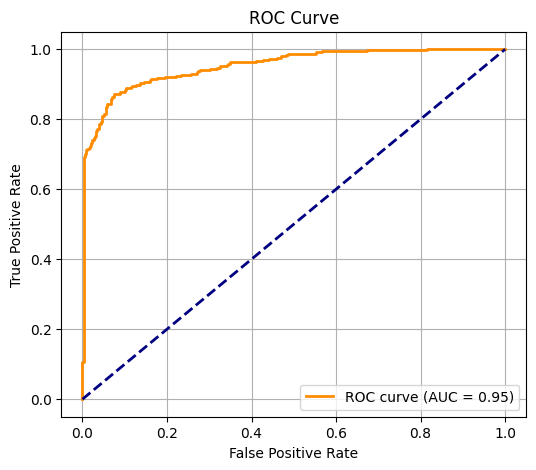

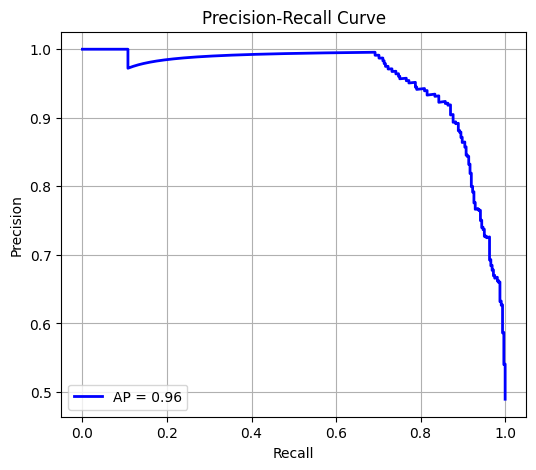

In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [ ]:
from torchvision.models import vgg16

vgg = vgg16(pretrained=True)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 2)
vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.7MB/s]


In [ ]:

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_acc = 0

for epoch in range(18):
    vgg.train()
    total_train_loss = 0
    correct_train, total_train = 0, 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, preds = outputs.max(1)
        correct_train += preds.eq(labels).sum().item()
        total_train += labels.size(0)

    train_acc = 100 * correct_train / total_train
    train_loss = total_train_loss / len(train_loader)

    
    vgg.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = vgg(imgs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, preds = outputs.max(1)
            correct_val += preds.eq(labels).sum().item()
            total_val += labels.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss = total_val_loss / len(val_loader)

    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(vgg.state_dict(), "best_vgg16.pth")
        print(f"Best Model Saved")

    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


100%|██████████| 21/21 [00:12<00:00,  1.66it/s]


Best Model Saved
Epoch 1 | Train Acc: 62.01%, Val Acc: 75.75%, Train Loss: 0.6432, Val Loss: 0.5028


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Best Model Saved
Epoch 2 | Train Acc: 72.17%, Val Acc: 80.12%, Train Loss: 0.5282, Val Loss: 0.4285


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Best Model Saved
Epoch 3 | Train Acc: 78.86%, Val Acc: 80.87%, Train Loss: 0.4500, Val Loss: 0.3827


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


Best Model Saved
Epoch 4 | Train Acc: 82.14%, Val Acc: 82.53%, Train Loss: 0.4033, Val Loss: 0.3459


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Epoch 5 | Train Acc: 84.20%, Val Acc: 82.08%, Train Loss: 0.3426, Val Loss: 0.3693


100%|██████████| 21/21 [00:12<00:00,  1.66it/s]


Epoch 6 | Train Acc: 85.73%, Val Acc: 77.56%, Train Loss: 0.3453, Val Loss: 0.4037


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


Epoch 7 | Train Acc: 85.69%, Val Acc: 76.81%, Train Loss: 0.3117, Val Loss: 0.4444


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


Epoch 8 | Train Acc: 86.70%, Val Acc: 80.12%, Train Loss: 0.2922, Val Loss: 0.3948


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


Epoch 9 | Train Acc: 88.01%, Val Acc: 80.12%, Train Loss: 0.2817, Val Loss: 0.3679


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


Epoch 10 | Train Acc: 88.68%, Val Acc: 82.38%, Train Loss: 0.2692, Val Loss: 0.3370


100%|██████████| 21/21 [00:12<00:00,  1.70it/s]


Epoch 11 | Train Acc: 90.29%, Val Acc: 80.12%, Train Loss: 0.2257, Val Loss: 0.5050


100%|██████████| 21/21 [00:12<00:00,  1.69it/s]


Best Model Saved
Epoch 12 | Train Acc: 90.21%, Val Acc: 88.10%, Train Loss: 0.2299, Val Loss: 0.3044


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


Epoch 13 | Train Acc: 91.93%, Val Acc: 84.64%, Train Loss: 0.1957, Val Loss: 0.3446


100%|██████████| 21/21 [00:12<00:00,  1.69it/s]


Epoch 14 | Train Acc: 90.89%, Val Acc: 79.97%, Train Loss: 0.2200, Val Loss: 0.4137


100%|██████████| 21/21 [00:12<00:00,  1.69it/s]


Epoch 15 | Train Acc: 92.90%, Val Acc: 82.98%, Train Loss: 0.1805, Val Loss: 0.3827


100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 16 | Train Acc: 94.25%, Val Acc: 78.77%, Train Loss: 0.1498, Val Loss: 0.5730


100%|██████████| 21/21 [00:12<00:00,  1.69it/s]


Epoch 17 | Train Acc: 93.43%, Val Acc: 82.23%, Train Loss: 0.1702, Val Loss: 0.3980


100%|██████████| 21/21 [00:12<00:00,  1.70it/s]

Epoch 18 | Train Acc: 94.58%, Val Acc: 77.86%, Train Loss: 0.1323, Val Loss: 0.6833


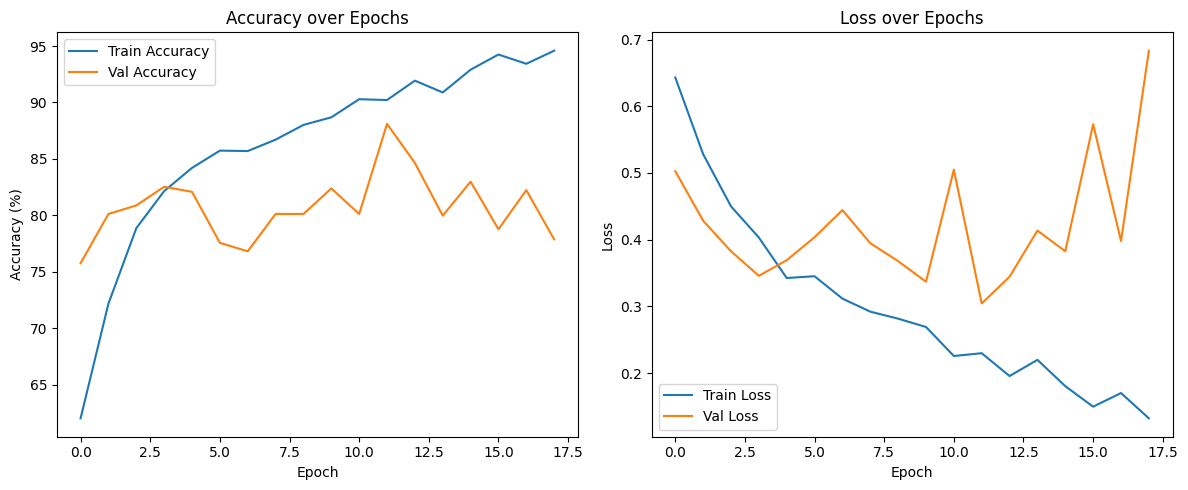

In [14]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

vgg.load_state_dict(torch.load("best_vgg16.pth"))
vgg.eval()

y_true, y_pred = [], []
y_scores = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = vgg(imgs)  # logits or probabilities
        probs = torch.softmax(outputs, dim=1)[:, 1]  # get score for class 1 (Malignant)

        _, preds = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())


print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


100%|██████████| 21/21 [00:12<00:00,  1.69it/s]

              precision    recall  f1-score   support

      Benign       0.86      0.92      0.89       339
   Malignant       0.91      0.84      0.87       325

    accuracy                           0.88       664
   macro avg       0.88      0.88      0.88       664
weighted avg       0.88      0.88      0.88       664



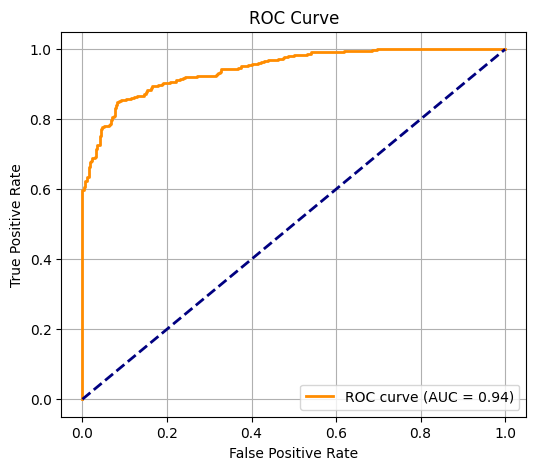

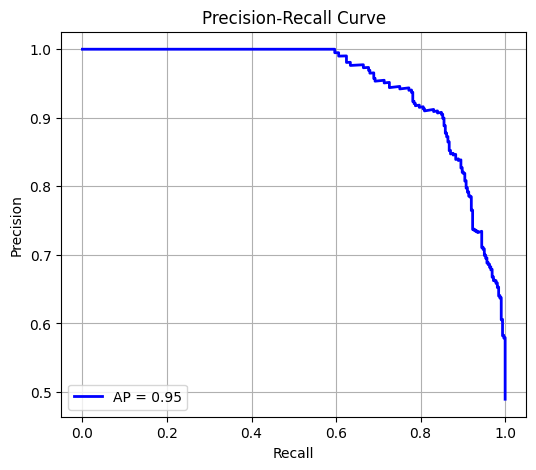

In [16]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

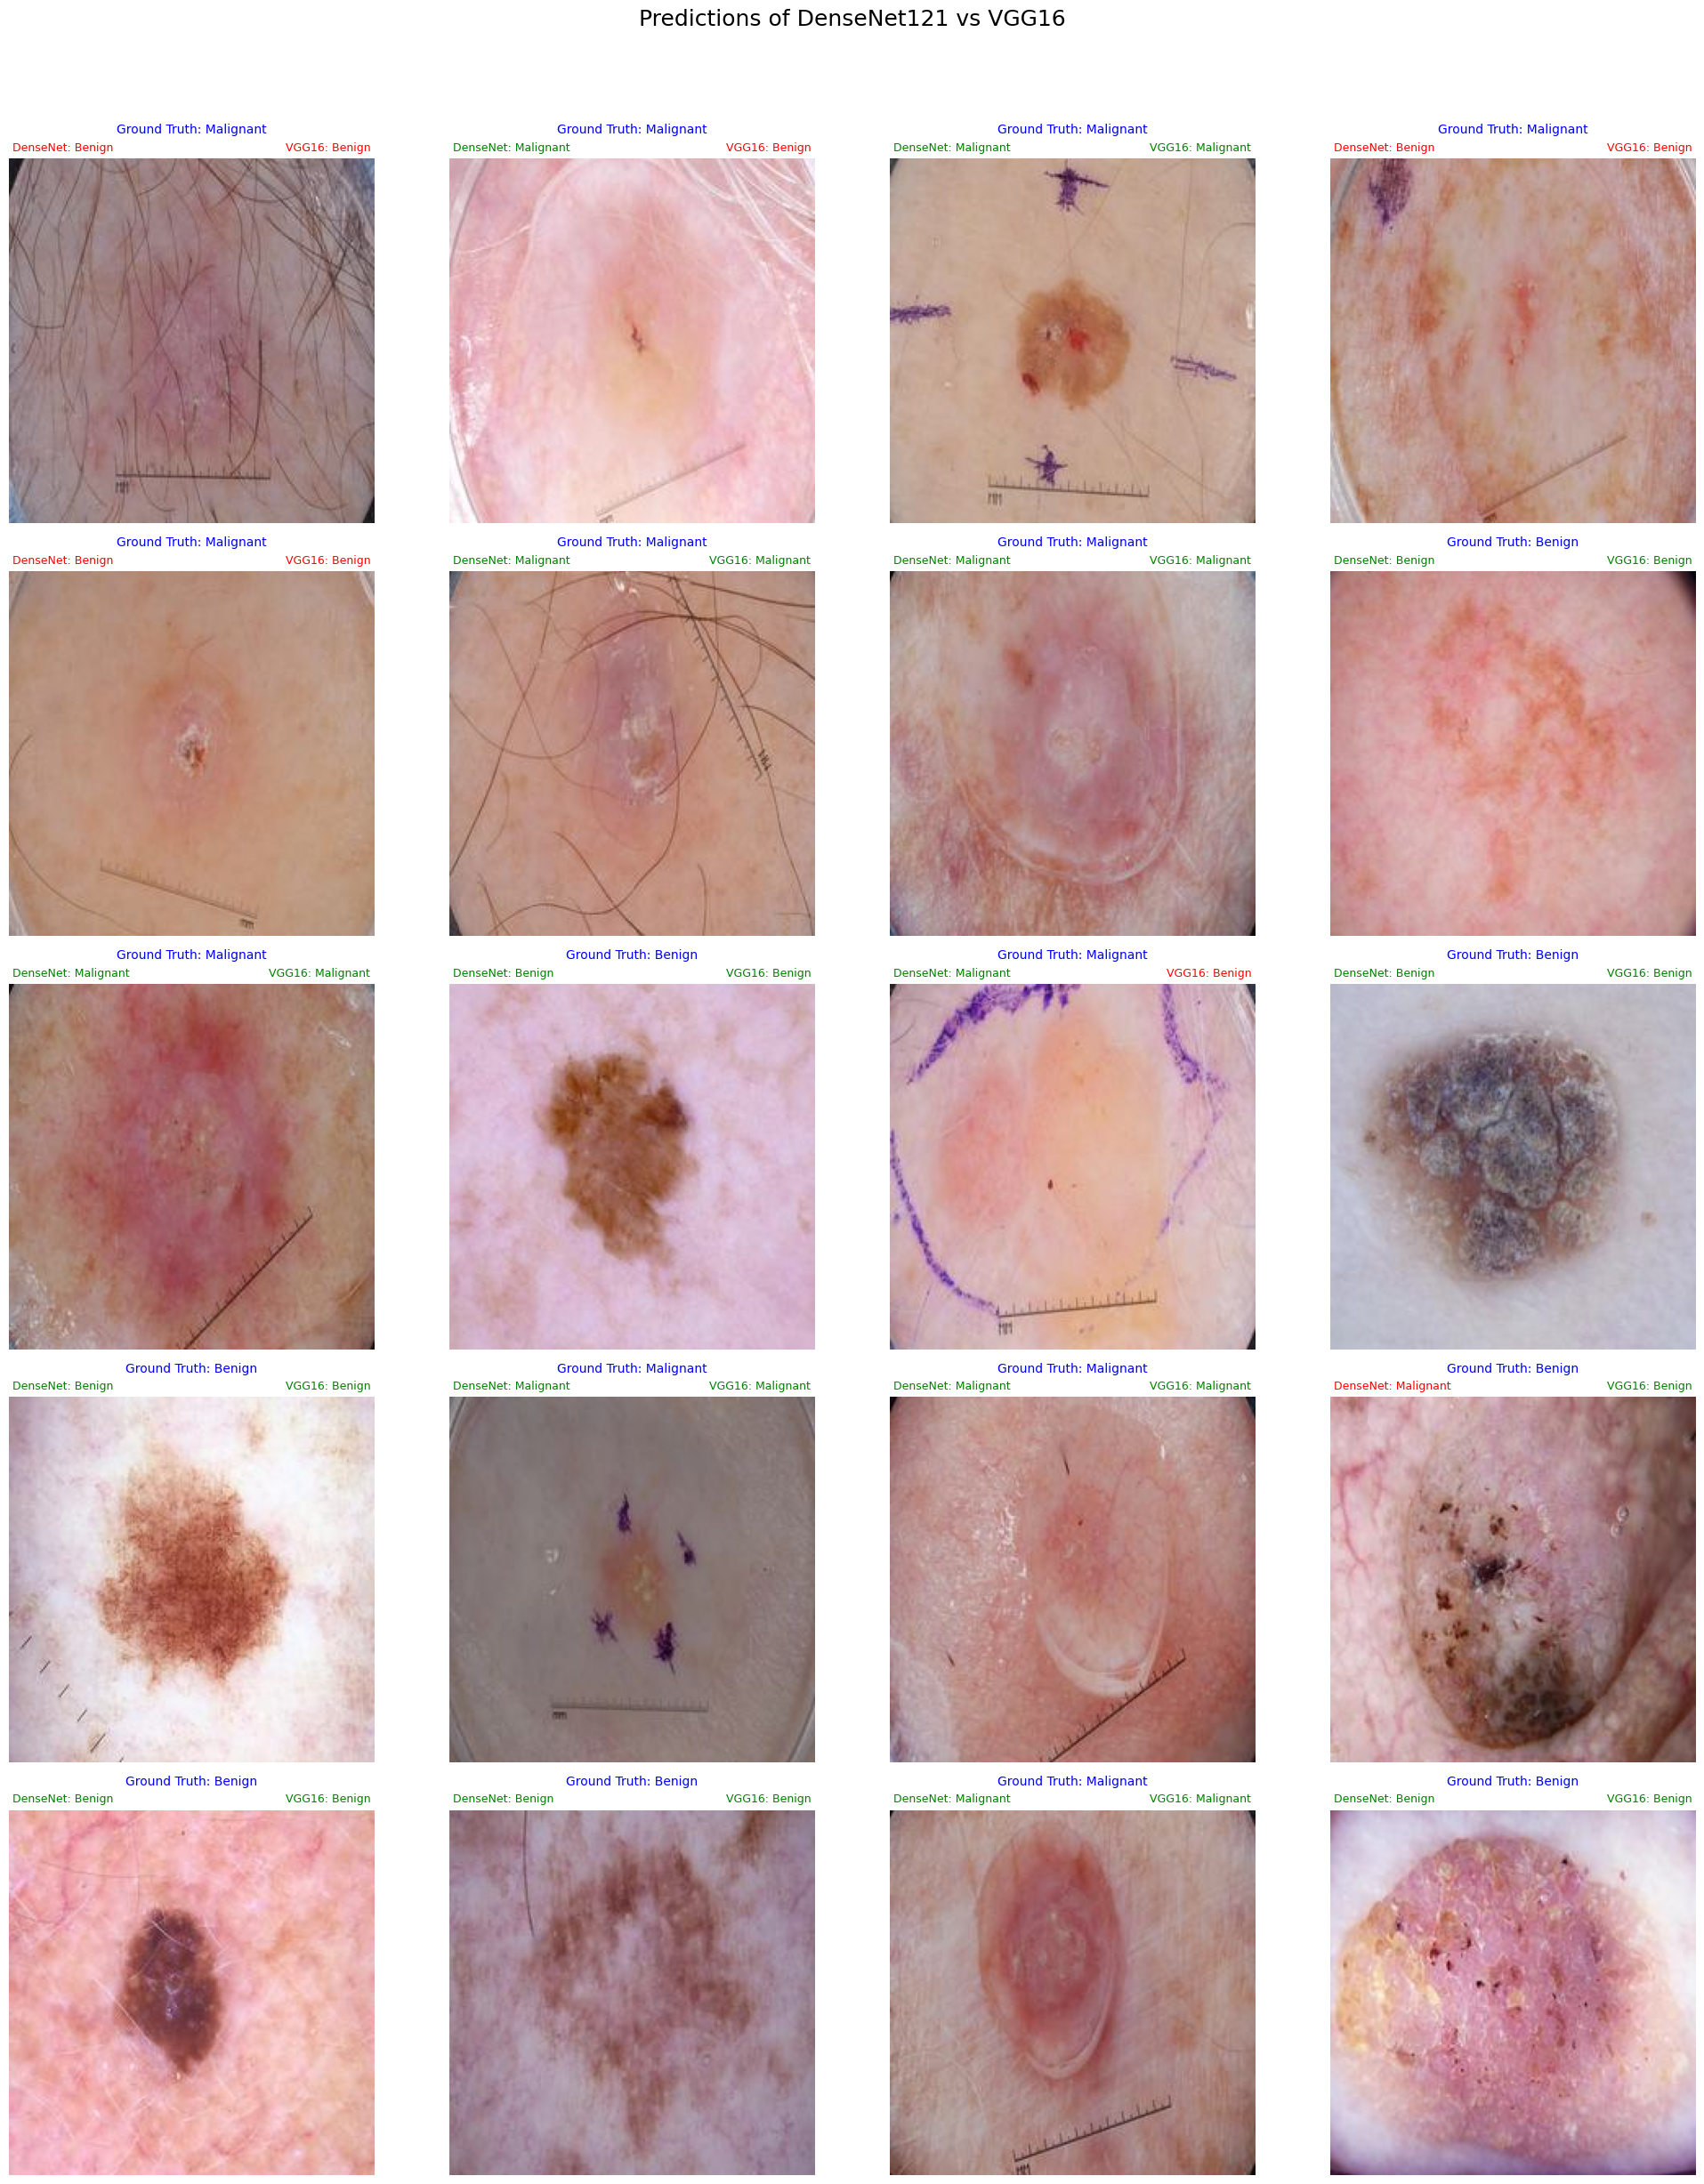

In [ ]:
import random


random.seed(42)

class_names = ["Benign", "Malignant"]


densenet = models.densenet121(pretrained=False)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 2)
densenet.load_state_dict(torch.load("best_model.pth"))
densenet.to(device).eval()

vgg = vgg16(pretrained=False)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 2)
vgg.load_state_dict(torch.load("best_vgg16.pth"))
vgg.to(device).eval()


all_test_paths = glob("/content/drive/MyDrive/ISIC Dataset/Test/*/*.jpg")
sample_paths = random.sample(all_test_paths, 20)

def preprocess_image(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = remove_hair(img)
    img = apply_clahe(img)
    #img = poly_transform(img)
    img = Image.fromarray(img)
    img = test_transform(img)
    return img.unsqueeze(0)  

def get_prediction(model, img_tensor):
    with torch.no_grad():
        return model(img_tensor).argmax(dim=1).item()

def get_label_color(pred, true_label):
    return 'green' if pred == true_label else 'red'


n_cols = 4
n_rows = (len(sample_paths) + n_cols - 1) // n_cols
plt.figure(figsize=(20, n_rows * 5))

for idx, path in enumerate(sample_paths):
    img_tensor = preprocess_image(path).to(device)
    true_label = 0 if "benign" in path.lower() else 1


    pred_dense = get_prediction(densenet, img_tensor)
    pred_vgg = get_prediction(vgg, img_tensor)


    img_disp = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

  
    ax = plt.subplot(n_rows, n_cols, idx + 1)
    ax.imshow(img_disp)
    ax.axis('off')


    ax.set_title(f"Ground Truth: {class_names[true_label]}", fontsize=10, color='blue', pad=20)


    ax.text(0.01, 1.02, f"DenseNet: {class_names[pred_dense]}",
            color=get_label_color(pred_dense, true_label), fontsize=9, transform=ax.transAxes, ha='left')
    ax.text(0.99, 1.02, f"VGG16: {class_names[pred_vgg]}",
            color=get_label_color(pred_vgg, true_label), fontsize=9, transform=ax.transAxes, ha='right')

plt.suptitle("Predictions of DenseNet121 vs VGG16", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


